In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os, sys
sys.path.append('../cnn-land-cover/scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision, torchsummary
import pytorch_lightning as pl
from pytorch_lightning.utilities.migration import pl_legacy_patch
import segmentation_models_pytorch as smp
import copy
from sklearn.manifold import TSNE 
from sklearn.manifold import TSNE 
sys.path.append('../reproducible_figures/scripts/')
import rep_fig_vis as rfv

In [4]:
## Load seco weights:
ckpt_path = '/Users/t.vanderplas/data/seco/seco_resnet50_1m.ckpt'
assert os.path.exists(ckpt_path)

with pl_legacy_patch():
    seco_sd = torch.load(ckpt_path, map_location='mps')['state_dict']\
    
## Load model from checkpoint:
LCU = lcm.LandCoverUNet(n_classes=6, lr=1e-3)

cross_entropy loss is used.


In [5]:
original_sd_keys = list(LCU.state_dict().keys())
seco_sd_keys = list(seco_sd.keys())

In [6]:

## create mapping of layer names:
mapping_seco_to_original = {}
encoder_use = 'q'
encoder_not_use = 'k' if encoder_use == 'q' else 'q'
for i_k, k in enumerate(seco_sd_keys):
    if k[:9] == f'encoder_{encoder_use}':
        new_k = k.replace(f'encoder_{encoder_use}', 'base.encoder')
    elif k[:9] == f'encoder_{encoder_not_use}':
        continue
    elif k[:5] == 'queue':
        continue 
    elif k[:7] == f'heads_{encoder_use}':
        continue 
    elif k[:7] == f'heads_{encoder_not_use}':
        continue 
    else:
        raise ValueError(k)
    
    if len(k.split('.')) > 3:
        map_layer_name = {'4': 'layer1', '5': 'layer2', '6': 'layer3', '7': 'layer4'}
        assert k[10] in map_layer_name.keys(), k[10]
        new_k = new_k.replace(f'.{k[10]}.', f'.{map_layer_name[k[10]]}.')
    elif len(k.split('.')) == 3:
        if k[10] == '0':
            new_k = new_k.replace('.0.', '.conv1.')
        elif k[10] == '1':
            new_k = new_k.replace('.1.', '.bn1.')
        else:
            raise ValueError(k)
        
    mapping_seco_to_original[k] = new_k
    
# mapping_seco_to_original[f'heads_{encoder_use}.0.0.weight'] = 'base.segmentation_head.0.weight'
# mapping_seco_to_original[f'heads_{encoder_use}.0.0.bias'] = 'base.segmentation_head.0.bias'

## create new state dict:
new_sd = {}
for k, v in seco_sd.items():
    if k in mapping_seco_to_original.keys():
        new_sd[mapping_seco_to_original[k]] = v
    else:
        # print(f'Key {k} not found in original state dict')
        pass

print(f'Original state dict had {len(original_sd_keys)} keys. Recover {len(new_sd.keys())} keys from SECO checkpoint.')
# print(f'Missing keys: {set(original_sd_keys) - set(new_sd.keys())}')
set_missing_keys = set(original_sd_keys) - set(new_sd.keys())
for k in set_missing_keys:
    assert k[:12] in ['base.decoder', 'base.segment'], k
print('No unexpected missing keys (only decoder layers are missing).')

## load new state dict:
LCU.load_state_dict(new_sd, strict=False)

Original state dict had 380 keys. Recover 318 keys from SECO checkpoint.
No unexpected missing keys (only decoder layers are missing).


_IncompatibleKeys(missing_keys=['base.decoder.blocks.0.conv1.0.weight', 'base.decoder.blocks.0.conv1.1.weight', 'base.decoder.blocks.0.conv1.1.bias', 'base.decoder.blocks.0.conv1.1.running_mean', 'base.decoder.blocks.0.conv1.1.running_var', 'base.decoder.blocks.0.conv2.0.weight', 'base.decoder.blocks.0.conv2.1.weight', 'base.decoder.blocks.0.conv2.1.bias', 'base.decoder.blocks.0.conv2.1.running_mean', 'base.decoder.blocks.0.conv2.1.running_var', 'base.decoder.blocks.1.conv1.0.weight', 'base.decoder.blocks.1.conv1.1.weight', 'base.decoder.blocks.1.conv1.1.bias', 'base.decoder.blocks.1.conv1.1.running_mean', 'base.decoder.blocks.1.conv1.1.running_var', 'base.decoder.blocks.1.conv2.0.weight', 'base.decoder.blocks.1.conv2.1.weight', 'base.decoder.blocks.1.conv2.1.bias', 'base.decoder.blocks.1.conv2.1.running_mean', 'base.decoder.blocks.1.conv2.1.running_var', 'base.decoder.blocks.2.conv1.0.weight', 'base.decoder.blocks.2.conv1.1.weight', 'base.decoder.blocks.2.conv1.1.bias', 'base.decoder.

# NB: normalisation

see `datasets/seco_dataset.py` for normalising procedure (clip between quantiles (given for RGB bands), then apply undefined'transform').

In [7]:
import pickle 
LCU = lcm.LandCoverUNet(n_classes=4)
LCU.load_state_dict(torch.load('/Users/t.vanderplas/models/LCU_2023_04_24_1259.pt')['model_state_dict'], strict=True)

cross_entropy loss is used.


<All keys matched successfully>

In [8]:
# model.encoder.forward
n_pix_side = 512
n_bands = 3
n_classes = 16


model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pretrained weights for encoder initialization
    in_channels=n_bands,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=n_classes,                      # model output channels (number of classes in your dataset)
)
model.encoder.load_state_dict(new_sd, strict=False)


im = torch.rand(1, n_bands, n_pix_side, n_pix_side)
tmp = model.encoder(im)
for _ in tmp:
    print(_.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 64, 256, 256])
torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 2048, 16, 16])


In [9]:
pd_ds = lcm.DataSetPatches(
    im_dir = '/Users/t.vanderplas/data/peak_district/pd_lc_annotated_patches_data/python_format/images_python_all/',
    mask_dir = '/Users/t.vanderplas/data/peak_district/pd_lc_annotated_patches_data/python_format/masks_python_all/',
    mask_suffix='_lc_2022_detailed_mask.npy',
    preprocessing_func=LCU.preprocessing_func,
    shuffle_order_patches=True,
    relabel_masks=False, 
    random_transform_data=False
)

Patches ordered randomly
Loaded 1027 patches
Loaded label_mapping_dict__main_categories__2023-04-20-1541.pkl just for meta data. Will not remap labels.


In [10]:
ex_input = pd_ds[0][0]
ex_input = ex_input[None, :, :, :]
assert ex_input.shape == im.shape, f'shape mismatch: {ex_input.shape} vs {im.shape}'
tmp = model.encoder(ex_input)

In [13]:
# dist_mat_seco = copy.deepcopy(dist_mat)

In [11]:
from tqdm import tqdm_notebook
# min_run = 90
# np.sqrt((min_run ** 2 * 4) * 2)
# n_ims = len(pd_ds)
n_ims = 200
dist_mat_mse = np.zeros((n_ims, n_ims)) 
dist_mat_eucledian = np.zeros((n_ims, n_ims))
total_iterations = n_ims * (n_ims - 1) // 2
method_change_shape_feature = 'mean_xy'
assert method_change_shape_feature in ['flatten', 'mean_xy']

dict_encodings = {}
for ii in tqdm(range(n_ims)):
    im1 = pd_ds[ii][0][None, :, :, :]
    encoding_1 = LCU.base.encoder(im1)[-1]
    if method_change_shape_feature == 'flatten':
        encoding_1 = encoding_1.flatten()
    elif method_change_shape_feature == 'mean_xy':
        encoding_1 = torch.mean(encoding_1, dim=(2, 3))
    dict_encodings[ii] = encoding_1

with tqdm_notebook(total=total_iterations) as pbar:
    for ii in range(n_ims):
        for jj in range(ii + 1, n_ims):
            encoding_1 = dict_encodings[ii]
            encoding_2 = dict_encodings[jj]
            dist_mat_mse[ii, jj] = torch.nn.functional.mse_loss(
                encoding_1, encoding_2, reduction='mean'
            ).item()
            dist_mat_eucledian[ii, jj] = torch.nn.functional.pairwise_distance(
                encoding_1, encoding_2, p=2
            ).item()        

            dist_mat_mse[jj, ii] = dist_mat_mse[ii, jj]
            dist_mat_eucledian[jj, ii] = dist_mat_eucledian[ii, jj]
            
            # Update the progress bar
            pbar.update(1)
        
        

100%|██████████| 200/200 [00:41<00:00,  4.86it/s]
/var/folders/vg/lgb0bh9x2yx0ny2lk_h8_ylc0000gr/T/ipykernel_64995/3443044599.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=total_iterations) as pbar:


  0%|          | 0/19900 [00:00<?, ?it/s]

In [144]:
# dist_mat = dist_mat_eucledian
dist_mat = dist_mat_mse
# dist_mat = dist_mat_seco

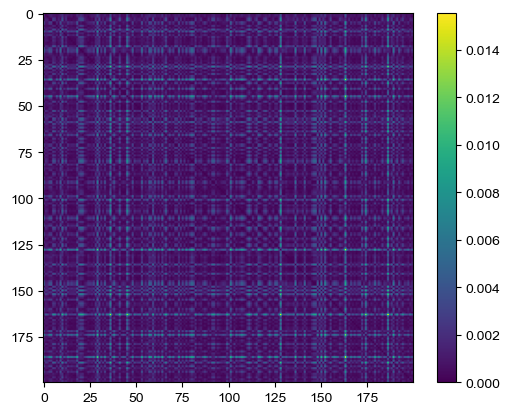

In [145]:
## set diag to nan
dist_mat[np.diag_indices_from(dist_mat)] = 0

plt.imshow(dist_mat)
plt.colorbar()

/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 't-SNE 2')

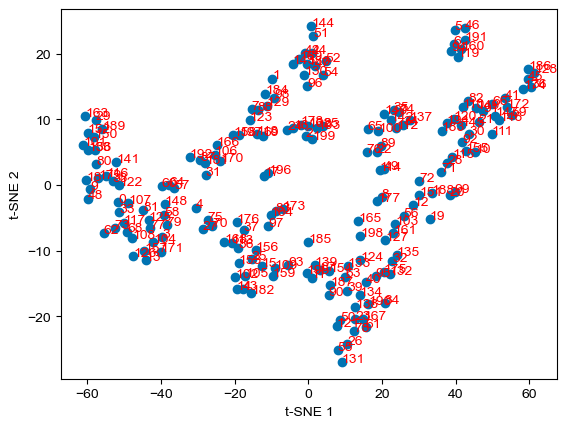

In [147]:

tsne = TSNE(n_components=2, perplexity=8, metric='precomputed')
tsne_res = tsne.fit_transform(dist_mat)

plt.scatter(tsne_res[:, 0], tsne_res[:, 1])
for i, (x, y) in enumerate(tsne_res):
    plt.text(x, y, str(i), color='red')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

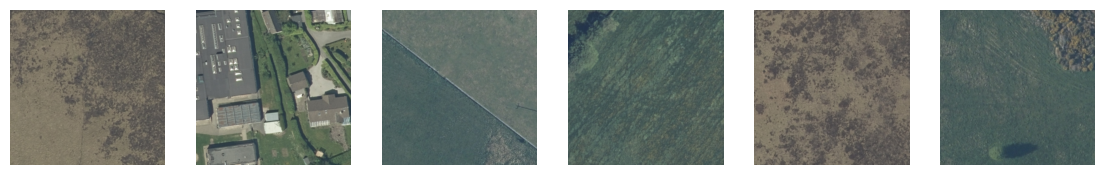

In [148]:
im_inds = [27, 90, 176, 150, 155, 24]
fig, ax = plt.subplots(1, len(im_inds), figsize=(14, 4))
for i_plot, i_im in enumerate(im_inds):
    curr_ax = ax[i_plot]
    curr_im = pd_ds[i_im][0]
    curr_im = lca.undo_zscore_single_image(curr_im, LCU.preprocessing_func)
    curr_im = curr_im.numpy()
    curr_im = np.squeeze(curr_im)
    lcv.plot_image_simple(curr_im, curr_ax)

Plotting 53 images


Text(-68.56620732879638, -26.676336431503294, 'tSNE 2')

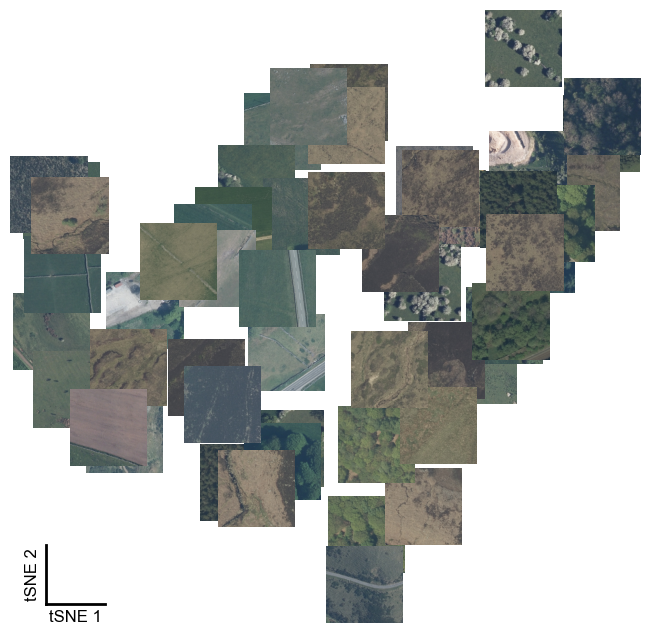

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), gridspec_kw={'wspace': 0, 'hspace': 0})
ax.scatter(tsne_res[:, 0], tsne_res[:, 1], alpha=0)
# rfv.equal_xy_lims(ax)
xlims = ax.get_xlim()
ylims = ax.get_ylim()

num_images = 64  # for grid 
frac_im = 1 / np.sqrt(num_images)
size_im_x = frac_im * (xlims[1] - xlims[0])
half_size_im_x = size_im_x / 2
size_im_y = frac_im * (ylims[1] - ylims[0])
half_size_im_y = size_im_y / 2

method_sampling = 'grid'
assert method_sampling in ['random', 'grid']

if method_sampling == 'random':
    selection_plot_im_inds = np.random.choice(np.arange(n_ims), size=20, replace=False)
elif method_sampling == 'grid':
    # Set the number of images to sample
    # num_images = 25

    # Generate evenly spaced coordinates
    x_coords = np.linspace(xlims[0], xlims[1], int(np.sqrt(num_images)) + 1)
    y_coords = np.linspace(ylims[0], ylims[1], int(np.sqrt(num_images)) + 1)
    x_coords = x_coords[:-1] + np.diff(x_coords) / 2
    y_coords = y_coords[:-1] + np.diff(y_coords) / 2

    # Create a grid of coordinates
    xx, yy = np.meshgrid(x_coords, y_coords)
    coords = np.vstack((xx.flatten(), yy.flatten())).T

    # Find the nearest neighbors in tsne_res
    # distances = np.sum((tsne_res[:, np.newaxis] - coords[np.newaxis]) ** 2, axis=2)
    distance_mat = np.zeros((n_ims, num_images))
    for ii in range(n_ims):
        for jj in range(num_images):
            distance_mat[ii, jj] = np.sqrt((tsne_res[ii, 0] - coords[jj, 0]) ** 2 + (tsne_res[ii, 1] - coords[jj, 1]) ** 2)
    assert distance_mat.shape[0] == n_ims
    nearest_indices = [np.argmin(distance_mat[:, i]) for i in range(num_images)]
    selection_plot_im_inds = np.unique(nearest_indices)
    print(f'Plotting {len(selection_plot_im_inds)} images')

# for i_grid in range(num_images):
#     x, y = coords[i_grid, :]
#     i_im = nearest_indices[i_grid]

for i_im in selection_plot_im_inds:
    x, y = tsne_res[i_im, :]
    # ax.text(x, y, str(i_im), color='red', zorder=2, ha='center', va='center')
    curr_im = pd_ds[i_im][0]
    curr_im = lca.undo_zscore_single_image(curr_im, LCU.preprocessing_func)
    curr_im = curr_im.numpy()
    curr_im = np.squeeze(curr_im)
    newax = ax.inset_axes([(x - half_size_im_x - xlims[0]) / (xlims[1] - xlims[0]), 
                          (y - half_size_im_y - ylims[0]) / (ylims[1] - ylims[0]), frac_im, frac_im], 
                         zorder=1, anchor='C')
    lcv.plot_image_simple(curr_im, newax)
    
# ax.set_xlabel('t-SNE 1')
# ax.set_ylabel('t-SNE 2')
ax.axis('off')
## create xy cross in SW corner:
ax.plot([xlims[0], xlims[0] + 0.1 * (xlims[1] - xlims[0])], [ylims[0], ylims[0]], color='black', linewidth=2)
ax.plot([xlims[0], xlims[0]], [ylims[0], ylims[0] + 0.1 * (ylims[1] - ylims[0])], color='black', linewidth=2)
ax.text(xlims[0] + 0.05 * (xlims[1] - xlims[0]), ylims[0] - 0.01 * (ylims[1] - ylims[0]), 'tSNE 1', 
        ha='center', va='top', color='black', fontsize=12)
ax.text(xlims[0] - 0.01 * (xlims[1] - xlims[0]), ylims[0] + 0.05 * (ylims[1] - ylims[0]), 'tSNE 2',
        ha='right', va='center', color='black', fontsize=12, rotation=90)


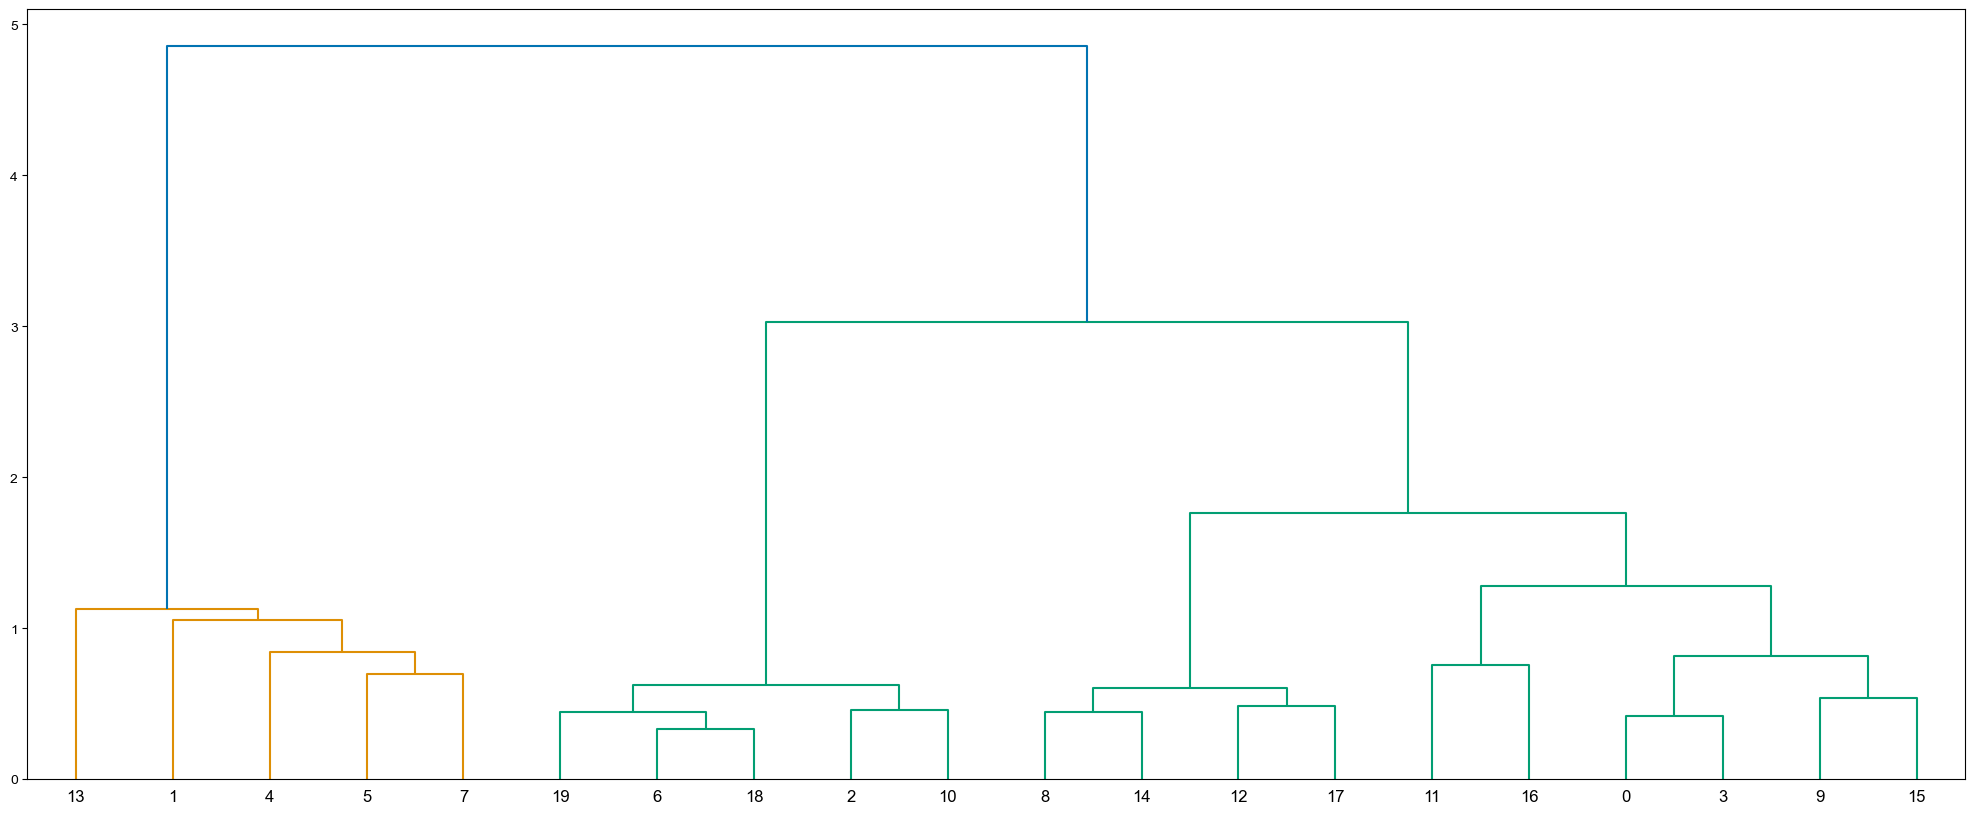

In [17]:
## hierarchical clustering:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

dist_mat_flat = squareform(dist_mat)
Z = linkage(dist_mat_flat, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()


In [47]:
# [(x - half_size_im - xlims[0]) / size_im, 
#                           (y - half_size_im - ylims[0]) / size_im, frac_im, frac_im]
xlims, x

(x - xlims[0]) #
#/ size_im
size_im

11.097092590332032

In [18]:
## save dist_mat: 
# np.save('dist_mat_lcu.npy', dist_mat_lcu) 

In [23]:
## get cluster labels:
from scipy.cluster.hierarchy import fcluster
max_d = 2
clusters = fcluster(Z, max_d, criterion='distance')
n_clusters = len(set(clusters))
print(f'Found {n_clusters} clusters.')

Found 3 clusters.


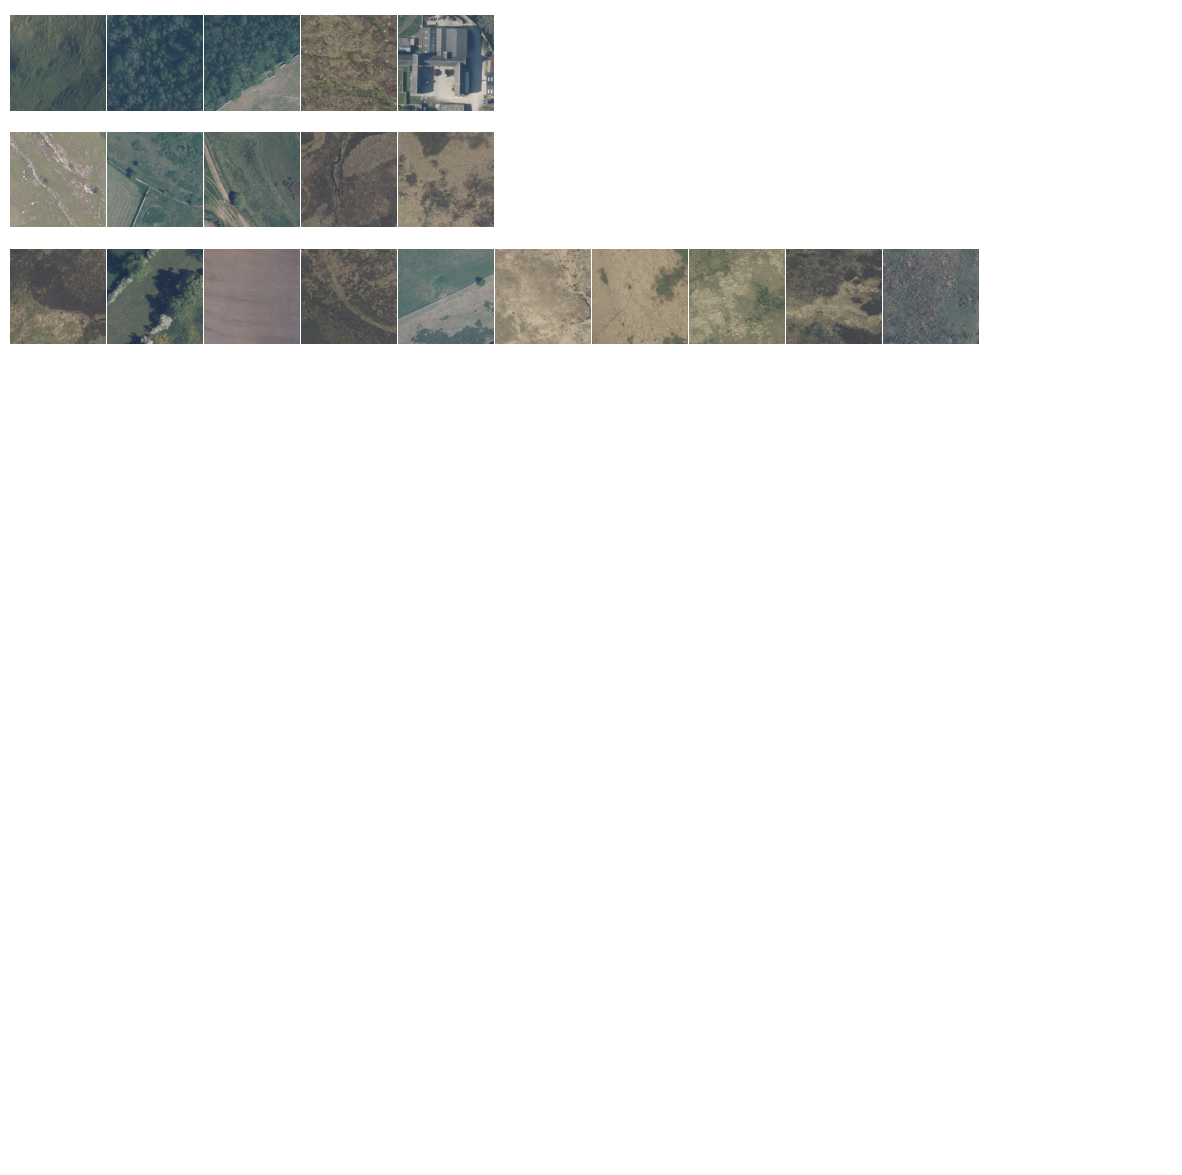

In [24]:
## Plot images in each cluster:
n_clusters_plot = 10
n_exampls_per_cluster = 12
fig, axs = plt.subplots(n_clusters_plot, n_exampls_per_cluster, figsize=(15, 15), gridspec_kw=dict(hspace=0.1, wspace=0.02))
for ii in range(n_clusters_plot):  # n_clusters):
    cluster_ims = np.where(clusters == ii + 1)[0]
    for jj in range(n_exampls_per_cluster):  # 10):
        axs[ii, jj].axis('off')
        if jj >= len(cluster_ims):
            continue
        curr_im = pd_ds[cluster_ims[jj]][0]
        curr_im = lca.undo_zscore_single_image(curr_im, LCU.preprocessing_func)
        curr_im = curr_im.numpy()
        curr_im = np.squeeze(curr_im)
        # assert False
        lcv.plot_image_simple(curr_im, ax=axs[ii, jj])
        if jj == 0:
            axs[ii, jj].set_ylabel(f'Cluster {ii + 1}')

In [41]:
curr_im.shape

(1, 3, 512, 512)